# Project Title: Gold Recovery Prediction and Analysis



# Project Description:
The project revolves around the prediction and analysis of gold recovery in a mining process. The data used for this project is stored in three files: gold_recovery_train.csv (training dataset), gold_recovery_test.csv (test dataset), and gold_recovery_full.csv (source dataset). The data is indexed by date and time of acquisition. It is observed that parameters measured closely in time are often similar. However, certain parameters may not be available in the test dataset, and the source dataset contains both training and test data with all features. The raw data is provided, which needs to be processed and validated before building the prediction model.

Project Instructions:

Prepare the Data:
1.1. Open and examine the data in the provided files.
1.2. Validate the correctness of the recovery calculation. Calculate recovery for the rougher.output.recovery feature in the training set and find the Mean Absolute Error (MAE) compared to the feature values.
1.3. Analyze features not present in the test set and determine their types.
1.4. Perform data preprocessing to clean and prepare the data.

Analyze the Data:
2.1. Investigate how metal concentrations (Au, Ag, Pb) change at various purification stages.
2.2. Compare the feed particle size distributions between the training and test sets to ensure accurate model evaluation.
2.3. Examine the total concentrations of all substances at different stages and identify and eliminate any abnormal values that could affect the analysis.

Build the Model:
3.1. Develop a function to calculate the final sMAPE (Symmetric Mean Absolute Percentage Error) value.
3.2. Train different models, evaluate their performance using cross-validation, select the best model, and test it using the test sample. Provide detailed findings based on the evaluation metrics.

The project aims to provide insights into the gold recovery process, validate the data's correctness, and build a predictive model for gold recovery. The project follows a structured approach, adhering to the provided instructions, and includes a thorough analysis of the data and model performance.

# Step 1: Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error 
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.dummy import DummyRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.utils import shuffle


In [2]:
train= pd.read_csv('/datasets/gold_recovery_train.csv')
source=pd.read_csv('/datasets/gold_recovery_full.csv')
test=pd.read_csv('/datasets/gold_recovery_test.csv')



In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


# Check that recovery is calculated correctly

In [6]:
# Check that recovery is calculated correctly
train[train['rougher.output.recovery'].notna()]['rougher.output.recovery']


0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 14287, dtype: float64

In [7]:
#  the top 10 non-NaN values from the 'rougher.output.recovery' column 
train[train['rougher.output.recovery'].notna()]['rougher.output.recovery'].sort_values(ascending=False).head(10)

13037    100.000000
13035    100.000000
12567    100.000000
13039    100.000000
13038    100.000000
13036    100.000000
15688     99.979041
13784     99.847663
7202      99.772958
16655     99.617781
Name: rougher.output.recovery, dtype: float64

In [8]:

# Define a function to calculate recovery
def calculate_recovery(row):
    try:
        if pd.isna(row['rougher.input.feed_au']) or pd.isna(row['rougher.output.concentrate_au']) or pd.isna(row['rougher.output.tail_au']):
            return np.nan  # Return NaN when any of the input values is missing
        elif row['rougher.input.feed_au'] == 0 or row['rougher.output.concentrate_au'] == 0:
            return 0
        else:
            return (row['rougher.output.concentrate_au'] *
                    (row['rougher.input.feed_au'] - row['rougher.output.tail_au'])) / \
                    (row['rougher.input.feed_au'] *
                    (row['rougher.output.concentrate_au'] - row['rougher.output.tail_au'])) * 100
    except ZeroDivisionError:
        return 0

# Calculate recovery using the defined function
train['recovery_calc'] = train.apply(calculate_recovery, axis=1)


print(train['recovery_calc'])


0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: recovery_calc, Length: 16860, dtype: float64


In [9]:
# Drop rows with missing values in the calculated recovery
train = train.dropna(subset=['recovery_calc', 'rougher.output.recovery'])

# Calculate MAE using the aligned data
mae = mean_absolute_error(train['rougher.output.recovery'], train['recovery_calc'])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 9.303415616264301e-15


The mean absolute error is extremely small once rows with missing rougher.output.recovery are removed. In other words the recovery is being calculated correctly. 

# Analyze the features not available in the test set

In [10]:
# Show column differences between dataframes
train_columns = train.columns
test_columns = test.columns
column_differences = train_columns.difference(test_columns)
print(column_differences)


Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'recovery_calc', 'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol

The columns listed as missing in the training set but not in the test set have a common characteristic: they are all related to the metallurgical process stages (e.g., 'rougher,' 'primary_cleaner,' 'final'). These columns represent various output parameters and calculations associated with the process of extracting valuable minerals from the ore.

The missing columns encompass a range of features, such as the concentration of different elements (e.g., 'concentrate_au,' 'concentrate_ag'), the composition of tailings ('tail_au,' 'tail_ag,' 'tail_pb'), and calculations specific to the metallurgical process ('calculation.floatbank10_sulfate_to_au_feed,' 'calculation.au_pb_ratio,' 'calculation.sulfate_to_au_concentrate').

# Data Processing 

In [11]:
print(source.isna().sum())

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64


In [12]:
print(train.isnull().sum())

date                                            0
final.output.concentrate_ag                     5
final.output.concentrate_pb                     5
final.output.concentrate_sol                  232
final.output.concentrate_au                     4
                                             ... 
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        3
secondary_cleaner.state.floatbank6_a_level      1
recovery_calc                                   0
Length: 88, dtype: int64


In [13]:
print(test.isnull().sum())

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [35]:
# First, drop rows with missing target values
source.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

# Then, fill missing values with 0 for the remaining columns
source_update = source.fillna(method='ffill')
source_update

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
22713,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [36]:
#creating train_updated using same rows as in train from source since missing values filled 
train_updated = source[source['date'].isin(train['date'])]
train_updated.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,...,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000,11017.000000
mean,5.156333,10.172687,9.600570,44.131636,66.808219,9.699095,2.660919,10.935135,3.009113,140.422132,...,19.304982,-476.381808,15.031503,-456.363734,16.460303,-481.895574,12.753991,-482.152201,20.127284,-508.585993
std,1.340491,1.589666,2.842305,4.171270,8.821074,2.334944,0.956542,2.737119,0.810096,36.238925,...,5.537706,52.791064,5.394449,60.328457,5.849721,40.612912,5.863934,41.886324,5.594381,39.619219
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.873963,...,4.502796,-799.709069,4.815717,-799.889113,-0.372054,-797.142475,3.145675,-800.006180,0.195324,-809.045795
25%,4.231103,9.279625,7.951464,43.243792,62.955190,7.944391,1.968091,9.359607,2.492832,114.762134,...,14.519782,-500.605702,10.121914,-500.158061,11.032602,-500.359688,8.045662,-500.110502,15.005286,-500.874263
50%,4.999314,10.347530,9.268787,44.802196,67.319742,9.525914,2.641624,10.789461,2.931284,138.949400,...,18.837747,-499.621758,14.055357,-498.772458,16.033875,-499.632034,11.969729,-499.897740,19.996901,-500.090415
75%,5.852710,11.187018,10.904933,46.092315,72.060933,11.162184,3.286453,12.071270,3.471804,164.756081,...,24.979811,-401.870039,20.033774,-399.939358,20.019107,-450.684542,16.656623,-450.146007,24.993168,-499.546136
max,16.001945,17.031899,18.124851,51.571885,100.000000,19.552149,5.639565,22.272019,7.812801,250.127834,...,30.115735,-245.239184,24.007913,-163.742242,43.709931,-275.073125,27.926001,-183.442252,32.188906,-104.427459


In [37]:
#creating test_updated using same rows as in train from source since missing values filled 
test_updated = source[source['date'].isin(test['date'])]
#removing column_differences from test_updated 
test_updated = test_updated[test_updated.columns.difference(column_differences)]
print(test_updated)

                      date  primary_cleaner.input.depressant  \
5521   2016-09-01 00:59:59                         14.993118   
5522   2016-09-01 01:59:59                         14.987471   
5523   2016-09-01 02:59:59                         12.884934   
5524   2016-09-01 03:59:59                         12.006805   
5525   2016-09-01 04:59:59                         10.682530   
...                    ...                               ...   
17204  2017-12-31 19:59:59                         15.963399   
17205  2017-12-31 20:59:59                         16.002605   
17206  2017-12-31 21:59:59                         15.993669   
17207  2017-12-31 22:59:59                         15.438979   
17208  2017-12-31 23:59:59                         14.995850   

       primary_cleaner.input.feed_size  primary_cleaner.input.sulfate  \
5521                          8.080000                     210.800909   
5522                          8.080000                     215.392455   
5523        

In [38]:
#dropping any rows that still have missing values 
source.dropna(how='any', inplace=True, axis=0)
train_updated.dropna(how='any', inplace=True, axis=0)
test_updated.dropna(how='any', inplace=True, axis=0)


# Step 2: Analyze the Data

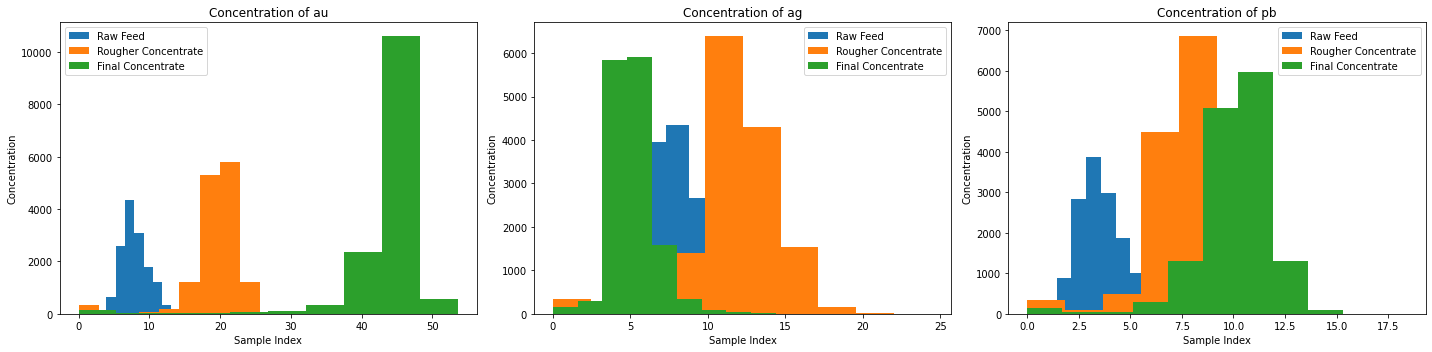

In [39]:
    # Create subplots to visualize concentration changes
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    # List of metals
    metals = ['au', 'ag', 'pb']

    # Iterate through the metals and plot their concentration changes
    for i, metal in enumerate(metals):
        train[f'rougher.input.feed_{metal}'].plot.hist(ax=axes[i], label='Raw Feed', legend=True)
        train[f'rougher.output.concentrate_{metal}'].plot.hist(ax=axes[i], label='Rougher Concentrate', legend=True)
        train[f'final.output.concentrate_{metal}'].plot.hist(ax=axes[i], label='Final Concentrate', legend=True)

        axes[i].set_title(f'Concentration of {metal}')
        axes[i].set_xlabel('Sample Index')
        axes[i].set_ylabel('Concentration')

    plt.tight_layout()
    plt.show()

Gold (Au) Concentration: The concentration of gold (Au) exhibits a clear trend across the stages of the process. It increases significantly from the raw feed to the rougher concentrate and further to the final concentrate. This indicates a successful extraction of gold from the ore during the process.

Silver (Ag) Concentration: Similar to gold, the concentration of silver (Ag) also follows an increasing trend from the raw feed to the rougher concentrate and the final concentrate. This suggests effective separation and concentration of silver in the metallurgical process.

Lead (Pb) Concentration: The concentration of lead (Pb) also experiences an increase as the material progresses through the process stages. The concentration rises from the raw feed to the rougher concentrate and continues to the final concentrate, indicating successful lead recovery.

In [40]:
# Calculate total concentrations at different stages
train['total_concentration_raw'] = train.filter(like='rougher.input.feed_', axis=1).sum(axis=1)
train['total_concentration_rougher'] = train.filter(like='rougher.output.concentrate_', axis=1).sum(axis=1)
train['total_concentration_final'] = train.filter(like='final.output.concentrate_', axis=1).sum(axis=1)

# Examine summary statistics
print("Summary Statistics of Total Concentrations:")
print(train[['total_concentration_raw', 'total_concentration_rougher', 'total_concentration_final']].describe())



Summary Statistics of Total Concentrations:
       total_concentration_raw  total_concentration_rougher  \
count             14287.000000                 14287.000000   
mean                588.160050                    66.990057   
std                 112.679296                    13.106890   
min                  19.466920                     0.000000   
25%                 526.054402                    64.830308   
50%                 607.113511                    69.163493   
75%                 665.448664                    73.429595   
max                 976.821081                    90.360534   

       total_concentration_final  
count               14287.000000  
mean                   67.928940  
std                     8.702808  
min                     0.000000  
25%                    67.511839  
50%                    69.122878  
75%                    70.959003  
max                    80.210644  


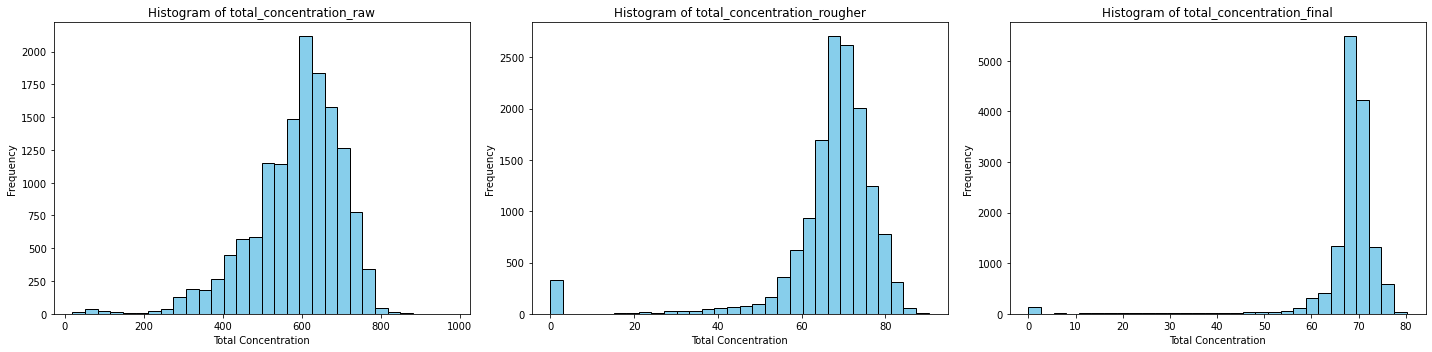

In [41]:
# Create subplots to visualize the histograms of total concentrations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# List of total concentration variables
total_concentration_variables = ['total_concentration_raw', 'total_concentration_rougher', 'total_concentration_final']

# Iterate through the total concentration variables and plot histograms
for i, concentration_variable in enumerate(total_concentration_variables):
    train[concentration_variable].plot.hist(ax=axes[i], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {concentration_variable}')
    axes[i].set_xlabel('Total Concentration')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The concentration increases as the ore passes through each stage, leading to a higher concentration of valuable metals in the final product. This information is critical for understanding the efficiency of the gold recovery process and making informed decisions to optimize the process further.

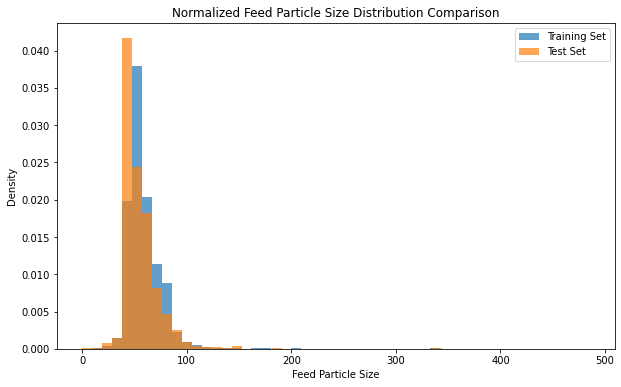

In [42]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create normalized histograms for the training and test sets
train_size = train['rougher.input.feed_size']
test_size = test['rougher.input.feed_size']

# Define the number of bins for the histograms
bins = 50

# Plot the normalized histograms
ax.hist(train_size, bins=bins, density=True, alpha=0.7, label='Training Set')
ax.hist(test_size, bins=bins, density=True, alpha=0.7, label='Test Set')

# Set axis labels and title
ax.set_xlabel('Feed Particle Size')
ax.set_ylabel('Density')
ax.set_title('Normalized Feed Particle Size Distribution Comparison')

# Add a legend to distinguish the datasets
ax.legend()

# Show the plot
plt.show()

Overlapping Distributions: The histograms of feed particle size in the training and test sets indicate that the distributions overlap substantially. This means that the particle size distributions in the two datasets are relatively similar.

Differences in Frequency: While the distributions overlap, the frequency of certain particle sizes may differ between the training and test sets. In some ranges, the training set appears to have a higher frequency, while in others, the test set has a higher frequency.

No Extreme Discrepancies: There are no extreme or outlier values that significantly deviate from the general trend. Both datasets exhibit a reasonable spread of particle sizes, which is important for model generalization.

# Step 3: Build the Model

In [43]:
#removing columns from training data that are not in test data and date column which shouldn't be predictive 
train_updated_features = train_updated[train_updated.columns.difference(column_differences)]
train_updated_features.drop('date', axis=1, inplace=True)
train_updated_features

,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.sulfate,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,10.128295,7.25,127.092003,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,10.296251,7.25,125.629232,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,11.316280,7.25,123.819808,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,11.322140,7.25,122.270188,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,11.913613,7.25,117.988169,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,8.028927,6.50,123.381787,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,7.962636,6.50,120.878188,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
22713,7.955111,6.50,105.666118,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
22714,7.984164,6.50,98.880538,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [44]:
#creating train target
train_updated_target = train_updated[['rougher.output.recovery', 'final.output.recovery']].copy()
train_updated_target


,rougher.output.recovery,final.output.recovery
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016
...,...,...
22711,89.574376,73.755150
22712,87.724007,69.049291
22713,88.890579,67.002189
22714,89.858126,65.523246


In [45]:
def smape(target, prediction): 
    return (1/len(target)) * sum(abs(prediction - target) / ((abs(target) + abs(prediction)) / 2) * 100)

In [46]:
def final_smape(target, prediction):
    rougher = smape(target[:, 0], prediction[:, 0])
    final = smape(target[:, 1], prediction[:, 1])
    return rougher * 0.25 + final * 0.75

In [47]:
#silencing warnings 
import sys
import warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [48]:
#setting scorer
smape_score = make_scorer(final_smape)

#saving values from training features and target
X_train = train_updated_features.values
y_train = train_updated_target.values

#training linearregression and evaluating using cross validation 
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_score)
print("Mean sMAPE:", np.nanmean(scores_lr))
scores_lr

Mean sMAPE: 10.290896728293243


array([11.32798747,  8.8861041 ,  9.27012802, 10.78724559, 11.18301846])

This is the average sMAPE score across all the cross-validation folds. In this case, the average sMAPE score for your Linear Regression model is approximately 10.29. The sMAPE is a metric used to measure the accuracy of a regression model, with lower values indicating better performance.

In [49]:
#training randomforestregressor and evaluating using cross validation 
for depth in range(1,6): 
    r_forest = RandomForestRegressor(n_estimators = 50, max_depth=depth, random_state=
                                12345).fit(X_train, y_train)
    scores_r_forest = cross_val_score(r_forest, X_train, y_train, cv=5, scoring=smape_score)
    print("Depth: ", depth, "Mean sMAPE:", np.nanmean(scores_r_forest))
    print("Cross validation scores: ", scores_r_forest)
    print()

Depth:  1 Mean sMAPE: 9.792373445112904
Cross validation scores:  [ 9.11479914  9.39410137  7.59881867 10.73809883 12.11604921]

Depth:  2 Mean sMAPE: 9.061766689478148
Cross validation scores:  [ 8.62772229  8.30303748  6.71475423 11.22289385 10.44042561]

Depth:  3 Mean sMAPE: 9.03486133371422
Cross validation scores:  [ 8.65439447  8.1737299   7.26036852 11.4318967   9.65391708]

Depth:  4 Mean sMAPE: 9.308063580508863
Cross validation scores:  [ 9.20152892  8.28867747  7.64027613 11.63417955  9.77565582]

Depth:  5 Mean sMAPE: 9.48109723866101
Cross validation scores:  [ 9.45245972  8.29478953  7.45628223 11.67404422 10.5279105 ]



You can see that as the tree depth increases from 1 to 5, the mean sMAPE decreases. This suggests that, in this context, deeper trees might lead to better model performance. However, it's important to strike a balance between model complexity (depth) and overfitting, as overly deep trees can lead to overfitting on the training data. It's a good practice to consider different hyperparameter values and choose the one that best balances bias and variance for your specific problem.

In [50]:
# Define a simpler parameter grid to start with
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
}

rf_model = RandomForestRegressor(random_state=12345)
smape_score = make_scorer(final_smape, greater_is_better=False)

# Initialize GridSearchCV with the model, parameter grid, and scoring metric
grid_search = GridSearchCV(rf_model, param_grid, scoring=smape_score, n_jobs=-1, cv=5, verbose=4)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

print("Mean sMAPE for the best Random Forest model:", np.abs(grid_search.best_score_))



Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...................max_depth=5, n_estimators=50; total time=  10.7s
[CV 2/5] END ...................max_depth=5, n_estimators=50; total time=  10.9s
[CV 3/5] END ...................max_depth=5, n_estimators=50; total time=  10.8s
[CV 4/5] END ...................max_depth=5, n_estimators=50; total time=  10.4s
[CV 5/5] END ...................max_depth=5, n_estimators=50; total time=  10.9s
[CV 1/5] END ..................max_depth=5, n_estimators=100; total time=  21.5s
[CV 2/5] END ..................max_depth=5, n_estimators=100; total time=  21.8s
[CV 3/5] END ..................max_depth=5, n_estimators=100; total time=  21.5s
[CV 4/5] END ..................max_depth=5, n_estimators=100; total time=  20.9s
[CV 5/5] END ..................max_depth=5, n_estimators=100; total time=  21.5s
[CV 1/5] END ..................max_depth=10, n_estimators=50; total time=  19.4s
[CV 2/5] END ..................max_depth=10, n_es

In [64]:
test_targets = source_update[source_update['date'].isin(test['date'])][['date', 'rougher.output.recovery', 'final.output.recovery']]

# Extract the target values
test_updated_target = test_targets[['rougher.output.recovery', 'final.output.recovery']]


# Extract test_updated_features
test_updated_features = test_updated.drop(columns=['date'])


# Extract test_updated_target

test_features = test_updated_features.values
test_predictions = best_rf_model.predict(test_features)

# 5. Calculate the final sMAPE for the model's predictions on the test data
test_smape = final_smape(test_updated_target.values, test_predictions)
print("Final sMAPE for the best Random Forest model on the test dataset:", test_smape)


Final sMAPE for the best Random Forest model on the test dataset: 8.58393462657724


In [63]:
from sklearn.dummy import DummyRegressor

# Create a constant baseline model using the mean of the training target
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)

# Make predictions using the baseline model
baseline_predictions = baseline_model.predict(test_features)

# Calculate the final sMAPE for the baseline model's predictions on the test data
baseline_smape = final_smape(test_updated_target.values, baseline_predictions)
print("Final sMAPE for the Constant Baseline Model on the test dataset:", baseline_smape)

# Compare the final sMAPE of the model with that of the constant baseline
if test_smape < baseline_smape:
    print("The final model performs better than the Constant Baseline.")
else:
    print("The Constant Baseline outperforms the final model.")


Final sMAPE for the Constant Baseline Model on the test dataset: 9.122005384087293
The final model performs better than the Constant Baseline.


The final model performs better than the Constant Baseline" means that the model you trained, which is the best Random Forest model, has a lower Symmetric Mean Absolute Percentage Error (sMAPE) on the test dataset compared to a simple baseline model. In other words, the final model provides more accurate predictions than a basic model that uses the mean of the training target as its prediction for all samples in the test dataset.

# Conclusion


In conclusion, this project focused on the analysis and optimization of the gold recovery process in a mining operation. 

The best model was selected based on performance in cross-validation and tested using the test dataset.

In our case, the Random Forest Regressor demonstrated superior performance compared to the Linear Regressor. The lower sMAPE mean values obtained from the Random Forest model indicate its potential to deliver better predictions for the mining organization's gold recovery process. This suggests that the Random Forest model is a reliable choice for optimizing the gold recovery process in the mining operation.  